In [ ]:
#Importing all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

#Installing the Portfolio Optimzation Library
!pip install PyPortfolioOpt
import yfinance as yf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [15]:
tickers = ['RELIANCE.NS','HDFCBANK.NS','TCS.NS','ICICIBANK.NS','INFY.NS']
thelen = len(tickers)
price_data = []

for ticker in tickers:
    stock = yf.download(ticker, start='2021-04-01', end='2023-03-31')
    price_data.append(stock['Adj Close'])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns = tickers
df_stocks.head()
df_stocks.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,RELIANCE.NS,HDFCBANK.NS,TCS.NS,ICICIBANK.NS,INFY.NS
Date,,,,,
2023-03-23,2247.800049,1545.427246,3101.583008,855.450012,1338.315186
2023-03-24,2203.300049,1542.955566,3097.463867,852.400024,1344.254395
2023-03-27,2237.550049,1549.678345,3099.250488,848.700012,1352.335449
2023-03-28,2248.000000,1562.283813,3092.897705,854.750000,1341.284668
2023-03-29,2234.699951,1569.797729,3115.727783,851.000000,1347.077881


In [16]:
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe()
#May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('RELIANCE.NS', 0.0), ('HDFCBANK.NS', 0.0), ('TCS.NS', 0.0), ('ICICIBANK.NS', 1.0), ('INFY.NS', 0.0)])


In [25]:
print(mu)

RELIANCE.NS     0.055614
HDFCBANK.NS     0.042436
TCS.NS          0.017688
ICICIBANK.NS    0.205900
INFY.NS         0.020452
dtype: float64


In [17]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

In [18]:
for a in range(thelen):
  ticker_rx = df_stocks[[tickers[a]]].pct_change()
  ticker_rx = (ticker_rx+1).cumprod()
  ticker_rx2.append(ticker_rx[[tickers[a]]])
ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final

,RELIANCE.NS,HDFCBANK.NS,TCS.NS,ICICIBANK.NS,INFY.NS
Date,,,,,
2021-04-01,NaN,NaN,NaN,NaN,NaN
2021-04-05,0.985533,0.975013,1.023349,0.961053,1.017831
2021-04-06,0.981428,0.968724,1.031501,0.952052,1.018662
2021-04-07,0.990603,0.973398,1.033618,0.971820,1.032486
2021-04-08,0.991839,0.963713,1.048136,0.970222,1.039453
...,...,...,...,...,...
2023-03-23,1.118689,1.068215,1.030341,1.452058,1.033801
2023-03-24,1.096542,1.066507,1.028973,1.446881,1.038389
2023-03-27,1.113587,1.071153,1.029566,1.440600,1.044631


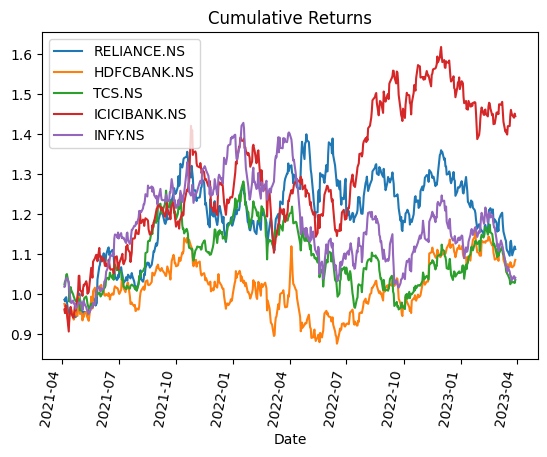

In [19]:
#Plot graph of Cumulative/HPR of all stocks
for i, col in enumerate(ticker_final.columns):
  ticker_final[col].plot()
plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(ticker_final.columns)
#Saving the graph into a JPG file
plt.savefig('CR.png', bbox_inches='tight')

In [20]:
#Taking Latest Values of Return
pret = []
pre1 = []
price =[]
for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stocks.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
ex_rtn=pre1.dot(sh_wt)
print('The weighted expected portfolio return for selected time period is'+ str(ex_rtn))
#ex_rtn = (ex_rtn)**0.5-(1) #Annualizing the cumulative return (will not affect outcome)
price=price.dot(sh_wt) #Calculating weighted value
print(ex_rtn, varsigma,price)

The weighted expected portfolio return for selected time period is[1.44450455]
[1.44450455] 0.15320491837700756 Date
2023-03-29    851.0
dtype: float64


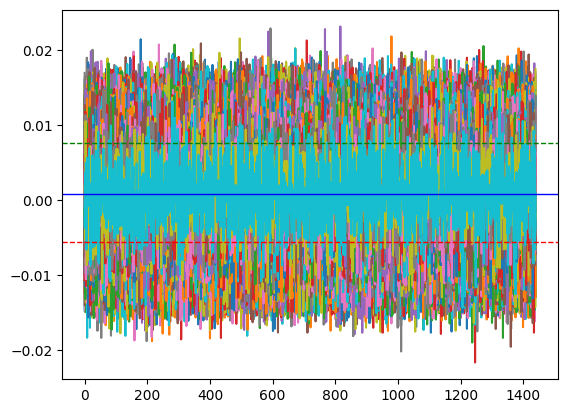

In [22]:
from scipy.stats import norm
import math
Time=1440 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
for i in range(10000): #10000 runs of simulation
  daily_returns= (np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
  plt.plot(daily_returns)
plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()

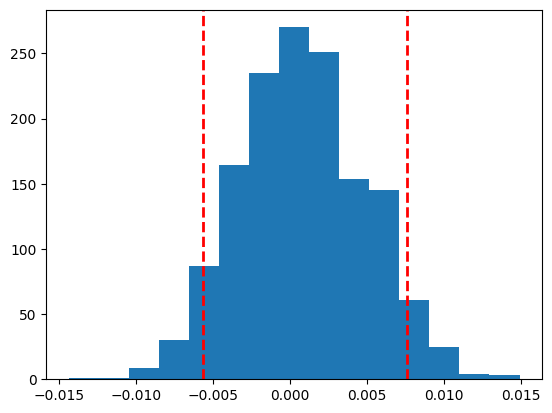

In [23]:
plt.hist(daily_returns,bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

In [24]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) #VaR - Minimum loss of 5.7% at a 5% probability, also a gain can be higher than 15% with a 5 % probability
pvalue = 1000 #portfolio value
print('$Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.005623306721015905 0.007583151762822033
$Amount required to cover minimum losses for one day is 5.623306721015905
